<a href="https://colab.research.google.com/github/anegrill/IDSN544/blob/main/IDSN_544_fast_ai_C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'd/aaronnegrillo/yelp-review-full-xiang-zhang-et-al-2015:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5736311%2F9439878%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240921%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240921T043031Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4214ffcf0f332da5694cc7b95325d946f11b93e275352463ee4d91812f7997d9f358182f7296d19d50d4fc871028a140f78d8831eb09986a70060d488af20d36673fb7e9c85fc6ee0a2cdeb5bf0db15380f390606859ab6bb5cbc99e6deec9b35ffe65e5b5f4fc740318fba0242038ef7a36c4cbae8a83dbe9475872702853a2b4675fdce0ac5fa163830036c9521c1c15118071a22353840abd9b6368a563ff48510e2521899c7fe7290c66a7dc6631f10982744e8eb2dcd97358209d91bdd1df6814bbe608504b3c119be2f052850983ccdaf84afacf3a65ae0bed8df7379206413b9e8d0ec042d7bd844d3185587e8faaf2787962a2133e997735da7d0dd0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 199990031 bytes downloaded
Downloaded and uncompressed: d/aaronnegrillo/yelp-review-full-xiang-zhang-et-al-2015
Data source import complete.


Aaron Negrillo <br>
IDSN 544, Fall 2024 <br>
anegrill@USC.edu

### fast.ai Chapter 4 Exercise - Natural Language Processing

For this exercise, we will use the fast.ai library to build a sample NLP model with the `AMAZON_REVIEWS` dataset.

In [ ]:
# pip install fastai --upgrade

In [2]:
# Import necessary modules
from fastai.text.all import *
from fastai.tabular.all import *
import os

In [3]:
# Define the path to the dataset
data_path = '../input/d/aaronnegrillo/yelp-review-full-xiang-zhang-et-al-2015/'

In [4]:
# List files in the dataset directory
files = os.listdir(data_path)
print(files)

['readme.txt', 'train.csv', 'test.csv']


In [5]:
# Load train and test datasets
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))

In [6]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649999 entries, 0 to 649998
Data columns (total 2 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Non-Null Count   Dtype 
---  ------                                                                                                                                                                                                                                                                                                                          

In [7]:
# Preview the Dataframe
train_df.head(5)

,5,"dr. goldberg offers everything i look for in a general practitioner. he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first. really, what more do you need? i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."
0,2,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I..."
1,4,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life."
2,4,Got a letter in the mail last week that said Dr. Goldberg is moving to Arizona to take a new position there in June. He will be missed very much. \n\nI think finding a new doctor in NYC that you actually like might almost be as awful as trying to find a date!
3,1,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you c..."
4,5,Top notch doctor in a top notch practice. Can't say I am surprised when I was referred to him by another doctor who I think is wonderful and because he went to one of the best medical schools in the country. \nIt is really easy to get an appointment. There is minimal wait to be seen and his bedside manner is great.


We seem to be missing headers, so let's assign those

In [8]:
# Set column names
column_names = ['Score','Review']

# Re-define our Dataframe and assign headers
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'), header=None, names=column_names)

In [9]:
# Preview the *updated* Dataframe
train_df.head(5)

,Score,Review
0,5,"dr. goldberg offers everything i look for in a general practitioner. he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first. really, what more do you need? i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."
1,2,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I..."
2,4,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life."
3,4,Got a letter in the mail last week that said Dr. Goldberg is moving to Arizona to take a new position there in June. He will be missed very much. \n\nI think finding a new doctor in NYC that you actually like might almost be as awful as trying to find a date!
4,1,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you c..."


In [ ]:
# # Pull sample text to test fastai default tokenizer
# textSample = train_df['Review'][0]
# print(textSample)

In [10]:
# Calculate Review lengths
train_df['Review_Length'] = train_df['Review'].apply(len)

count    650000.000000
mean        732.325468
std         663.721184
min           1.000000
25%         287.000000
50%         539.000000
75%         957.000000
max        5637.000000
Name: Review_Length, dtype: float64


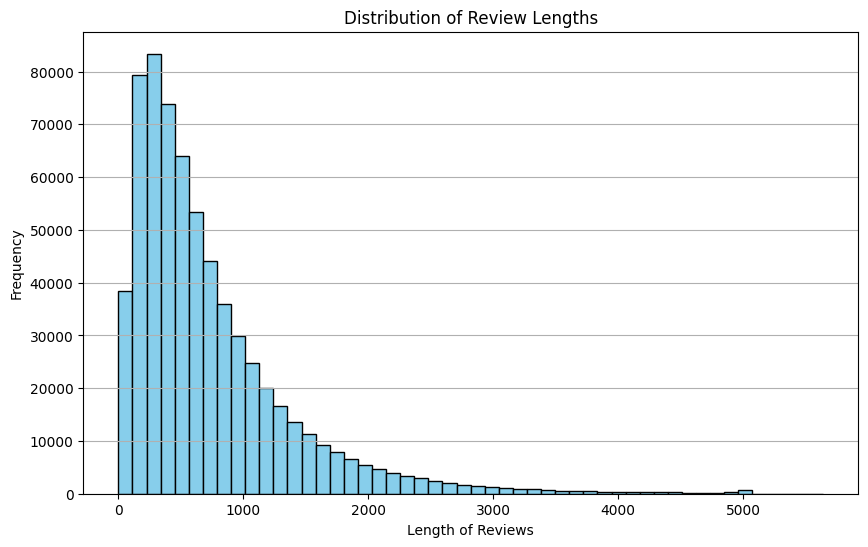

In [11]:
# Summary statistics
length_stats = train_df['Review_Length'].describe()
print(length_stats)

# Visualize Review length distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train_df['Review_Length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Given the distribution, we might want to limit our reviews to an upper and lower bound.

In [12]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = train_df['Review_Length'].quantile(0.25)
Q3 = train_df['Review_Length'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

count    614557.000000
mean        617.512664
std         438.327594
min           1.000000
25%         274.000000
50%         506.000000
75%         864.000000
max        1962.000000
Name: Review_Length, dtype: float64


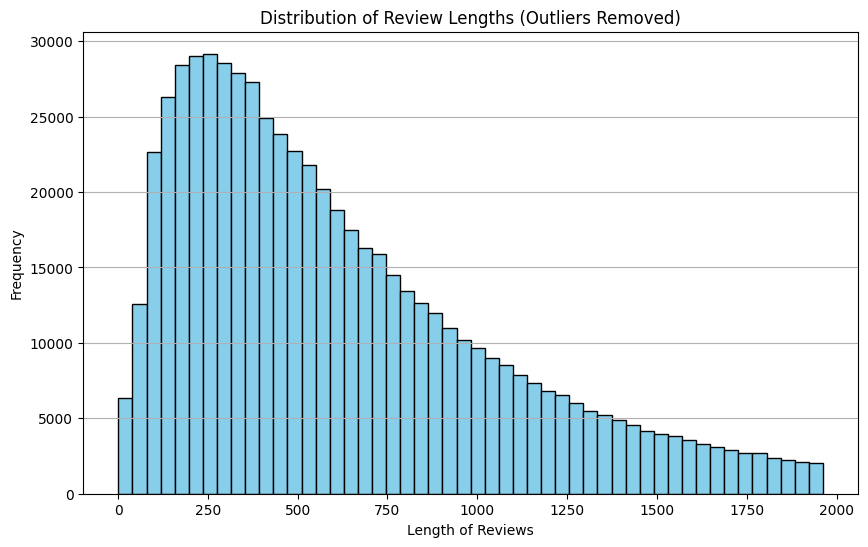

In [13]:
# Filter the DataFrame to remove outliers
filtered_train_df = train_df[(train_df['Review_Length'] >= lower_bound) &
                              (train_df['Review_Length'] <= upper_bound)]

# Check the new summary statistics
print(filtered_train_df['Review_Length'].describe())

# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(filtered_train_df['Review_Length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths (Outliers Removed)')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Pre-Filtered 75th Percentile Length ~ 960
Filtered 75th Percentile Lenght ~ 900 (with buffer, from 864)

For our purposes let's experiment with the unfiltered model, starting at 960 and adjusting from there

In [19]:
# Test tokenizer function and output
fastAITokenizer = WordTokenizer()

# Pre-tokenize dataframe
train_df['Review'] = train_df['Review'].apply(fastAITokenizer)

# Preview the Dataframe
train_df.head(5)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,Score,Review,Review_Length
0,5,<generator object SpacyTokenizer.__call__.<locals>.<genexpr> at 0x7cd044db5850>,534
1,2,<generator object SpacyTokenizer.__call__.<locals>.<genexpr> at 0x7cd044db5930>,643
2,4,<generator object SpacyTokenizer.__call__.<locals>.<genexpr> at 0x7cd044db5a10>,495
3,4,<generator object SpacyTokenizer.__call__.<locals>.<genexpr> at 0x7cd044db5af0>,261
4,1,<generator object SpacyTokenizer.__call__.<locals>.<genexpr> at 0x7cd044db5bd0>,1143


In [20]:
# Building our Training* DataFrame -- will split this
dls = TextDataLoaders.from_df(
    train_df,
    text_col='Review',
    label_col='Score',
    valid_pct=0.2,
    seq_len=500,
    bs=128,
    seed=42
)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [28]:
print(f'Train dataset size: {len(train_df)}')

Train dataset size: 650000


In [21]:
# Preview our *Tokenized* DataLoader
dls.show_batch(max_n=2)

,text,category
0,xxbos < generator object spacytokenizer.__call__.<locals>.<genexpr > at 0x7cd xxrep 3 0 7 xxrep 3 a 40 >,1
1,xxbos < generator object spacytokenizer.__call__.<locals>.<genexpr > at 0x7cd01b xxrep 3 5 fc0 >,5


In [29]:
# Building the Learner
learnNLP = text_classifier_learner(
    dls,
    AWD_LSTM,
    drop_mult=0.3,
    metrics=[accuracy, Perplexity()]
).to_fp16()

/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

In [30]:
# Intermediate Model Results
learnNLP.fit_one_cycle(1, 2e-2)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.609862,1.609508,0.200769,5.000352,12:02


In [31]:
learnNLP.save('1epoch')
learnNLP = learnNLP.load('1epoch')

Path('models/1epoch.pth')

In [32]:
learnNLP.unfreeze()
learnNLP.fit_one_cycle(10, 2e-3)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.609809,1.609502,0.199408,5.000319,12:16
1,1.609501,1.609644,0.200085,5.001029,12:17
2,1.609495,1.609828,0.200908,5.001948,12:19
3,1.609651,1.611137,0.199323,5.008503,12:06
4,1.609344,1.609675,0.199877,5.001186,12:13
5,1.609628,1.609631,0.199377,5.000966,12:10
6,1.609414,1.609541,0.200085,5.000515,12:08
7,1.609493,1.609442,0.201077,5.000020,12:01
8,1.609440,1.609432,0.201200,4.999971,12:08
9,1.609420,1.609435,0.201077,4.999987,12:03


In [33]:
learnNLP.save_encoder('finetuned')

In [38]:
# dls.vocab

In [40]:
# Use the vocab from dls directly
vocab = dls.vocab

# Print the type and some sample values from the vocab
print(f"Type of vocab: {type(vocab)}")
print(f"Sample vocab items: {vocab[:10]}")  # Print first 10 items in the vocab

Type of vocab: <class 'fastcore.foundation.L'>
Sample vocab items: [['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', '>', '<', 'generator', 'object', 'spacytokenizer.__call__.<locals>.<genexpr', 'at', '3', '0', '0x7cd', '4', 'f', '0x7cd0', '0x7cc', '6', '0x7cd04', '5', '7', '9', 'c', 'b', 'd', 'a', '2', '8', '40', '1', 'e', 'a0', '50', '0x7cd03', '0x7cd06', 'b0', '30', 'c0', '90', '20', '0x7cd01', '60', 'd0', '0x7cd061', '10', 'f0', '0x7cd02e', '0x7ccfe', '0x7ccfd', '0x7cd049', '0x7cd07', '0x7cd030', '00', 'e0', '80', '70', '0x7cd047', '0x7cd048', '0x7cd03f', '0x7cd03c', '0x7cd036', '0x7cd040', '0x7cd03b', '0x7ccfde', '0x7cd037', '0x7cd065', '0x7cd04e', '0x7cd04b', '0x7cd04d', '0x7cd03d', '0x7cd04a', '0x7cd060', '0x7ccff7', '0x7cd046', '0x7cd062', '0x7cd043', '0x7cd019', '0x7ccfe7', '0x7cd04c', '0x7cd064', '0x7cd032', '0x7cd063', '0x7cd045', '0x7cd039', '070', '230', '310', '3f0', '4d0', '690', '770', '850', 'a10', 'af0', 'bd0', 'cb0', 'e70', 'f50', '0d

In [ ]:
# Define your get_y function
def get_y(row):
    return row['Score']

# Ensure vocab is a simple list (not a list of lists)
vocab = [item for sublist in dls.vocab for item in sublist]

# Create DataBlock for classification
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('Review', vocab=vocab, seq_len=500), CategoryBlock),
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Create DataLoaders
dls_C = dls_clas.dataloaders(train_df, bs=128)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
